In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.special import logsumexp
import scipy.sparse as sp
import networkx as nx

#### General procedure:

1. Initialize all the parameters, say, $\mu, a, z$;
2. For all the data pairs $(C_k, T_k)$, where $C_k$ is the crossed boundary and $T_k$ is the first passage time, compute the probability $\mathbb{P}(\tilde{X}_{\lfloor T_k/\Delta t\rfloor}=C_k)$;
3. For the approximate process, 
4. 
5.

In [2]:
def MCsample(P, init_dist, k): 
    """
    sample a 'k'-step Markov chain 
    with initial distribution 'init_dist'
    and transition probabilities 'P'
    """
    s = len(init_dist) # num of states
    X = np.zeros(k)
    X[0] = np.random.choice(s, p=init_dist)
    for i in range(1, k):
        X[i] = np.random.choice(s, p=P[int(X[i-1]), :])
    return X


#### Ways to prevent numerical underflow
(1) Let $b_i=\log a_i$,
$$
\begin{aligned}
\log\left(\textstyle \sum_{i=1}^n a_i\right)&=\log\left(\textstyle\sum_{i=1}^n e^{b_i}\right)=\log\left(\textstyle e^{b_{\max}}\sum_{i=1}^n e^{b_i-b_{\max}}\right)=b_{\max}+\log \left(\textstyle \sum_{i=1}^n e^{b_i-b_{\max}}\right)\\
&=\operatorname{logsumexp}\left(\boldsymbol{b}\right)
\end{aligned}
$$
(2) 


In [3]:
def logdotexp(A, B):
    """
    numerically stable ways to compute
    np.log(np.dot(np.exp(A), np.exp(B)))
    A, B are 2d arrays satisfying A.shape[1] = B.shape[0]
    """
    assert len(A.shape) == 2
    assert len(B.shape) == 2
    assert A.shape[1] == B.shape[0]
    A_ = np.stack([A] * B.shape[1]).transpose(1, 0, 2)
    B_ = np.stack([B] * A.shape[0]).transpose(0, 2, 1)
    return logsumexp(A_ + B_, axis=2)


advection-diffusion equation:
$$
\begin{aligned}
u_t+cu_x&=\nu u_xx\\
u(x,0)&=f(x)\\
u(0,t)&=u(a,t)=0\\
\end{aligned}
$$
Crank-Nicolson:
$$
\begin{aligned}
\tfrac{u_j^{n+1}-u_j^n}{\Delta t}+\tfrac{c}{2} \left(\tfrac{u_{j+1}^{n+1}-u_{j-1}^{n+1}}{2 \Delta x}+\tfrac{u_{j+1}^n-u_{j-1}^n}{2 \Delta x}\right)&=\tfrac{\nu}{2} \tfrac{u_{j+1}^n-2 u_j^n+u_{j-1}^n}{(\Delta x)^2}+\tfrac{\nu}{2} \tfrac{u_{j+1}^{n+1}-2 u_j^{n+1}+u_{j-1}^{n+1}}{(\Delta x)^2}\\
u^{0}_{j}&=f(x_j)\\
u^j_{0}&=u^j_{N_x}=0
\end{aligned}\\
$$
which can be simplified as
$$
\left(-\tfrac{\lambda}{4}-\tfrac{\mu}{2}\right) u_{j-1}^{n+1}+(1+\mu) u_j^{n+1}+\left(\tfrac{\lambda}{4}-\tfrac{\mu}{2}\right) u_{j+1}^{n+1}=\left(\tfrac{\lambda}{4}+\tfrac{\mu}{2}\right) u_{j-1}^n+(1-\mu) u_j^n+\left(-\tfrac{\lambda}{4}+\tfrac{\mu}{2}\right) u_{j+1}^n
$$

In [4]:
def solve_ADVD(c, D, x_range, t_range, f, Nx, Nt):
    """Solve
    u_t + c * u_x = D * u_xx
    with initial condition f(x) and homogeneous Dirichlet boundary
    """
    # Crank-Nicolson
    xmin, xmax = x_range
    tmin, tmax = t_range
    x_grid = np.linspace(xmin, xmax, Nx + 1)
    t_grid = np.linspace(tmin, tmax, Nt + 1)
    dx = x_grid[1] - x_grid[0]
    dt = t_grid[1] - t_grid[0]
    lam = c * dt / dx
    mu = D * dt / dx ** 2
    u_grid = np.zeros([Nx + 1, Nt + 1])
    u_grid[:, 0] = f(x_grid)

    I = np.eye(Nx - 1)
    I1 = np.diag(np.ones(Nx-2), 1)
    I2 = np.diag(np.ones(Nx-2), -1)
    A = (1 + mu) * I - (lam / 4 + mu / 2) * I1 + (lam / 4 - mu / 2) * I2
    B = 2 * I - A
    C = np.linalg.solve(A, B)

    for t_step in range(Nt):
        u_grid[1:-1, t_step + 1] = C @ u_grid[1:-1, t_step]

    return x_grid, t_grid, u_grid

In one spatial dimension $x$, for an Itô process driven by the standard Wiener process $W_t$ and described by the stochastic differential equation (SDE)
$$
\begin{aligned}
\mathrm{d} X(t)&=\mu\left(X(t), t\right) \mathrm{d} t+\sigma\left(X(t), t\right) \mathrm{d} W(t)\\
X(t)&=X(0)+\int_0^t \mu(X(s), s) \mathrm{d} s+\int_0^t \sigma(X(s), s) \mathrm{d}W(s)
\end{aligned}
$$
with drift $\mu(X(t), t)$ and diffusion coefficient $\sigma^2(X(t), t)/2$, the Kolmogorov forward equation (Fokker-Planck equation) for the transition probability density $f(x,t|y,s)$ (defined as $f(x,t|y,s)\mathrm{d}x=\mathbb{P}(X(t)\in[x,x+\mathrm{d}x)|X(s)=y)$) of the random variable $X(t)$ is
$$
\tfrac{\partial}{\partial t} f(x, t|y, s)=-\tfrac{\partial}{\partial x}[\mu(x, t) f(x, t|y,s)]+\tfrac{1}{2}\tfrac{\partial^2}{\partial x^2}[\sigma^2(x, t) f(x, t|y,s)],\text{ for } t\ge s
$$
the Kolmogorov backward equation is
$$
\tfrac{\partial}{\partial s} f(x, t|y,s)=-\mu(x, t) \tfrac{\partial}{\partial y} f(x, t|y,s)-\tfrac{1}{2} \sigma^2(x, t) \tfrac{\partial^2}{\partial y^2} f(x, t|y,s),\text{ for } s< t
$$


### Drift-diffusion model
Consider the following stochastic process on the interval $[0, a]$ with absorbing boundaries:
$$
\begin{aligned}
\mathrm{d} X(t)&=\mu(t)\mathrm{d} t +\sigma\mathrm{d} W(t)\\
X(t)&=z+\int_{0}^{t}\mu(r)\mathrm{d} r +\sigma W(t)
\end{aligned}
$$
with starting point $z\in(0, a)$.

The Fokker-Planck equation corresponds to drift-diffusion model is
$$
\begin{aligned}
\tfrac{\partial}{\partial t} f(x, t|z,0)&=-\mu\tfrac{\partial}{\partial x}f(x, t|z,0)+\tfrac{1}{2}\sigma^2\tfrac{\partial^2}{\partial x^2}f(x, t|z,0)\\
f(x, 0|z,0)&=\delta(x-z)\\
f(0,t|z,0)&=f(a,t|z,0)=0
\end{aligned}
$$

In [73]:
class DDModel(object):
    def __init__(self, mu=1, sigma=1) -> None:
        self.mu = mu
        self.sigma = sigma

    def strong_Euler(self, init_cond, T, Nt=1000):
        t0, u0 = init_cond
        dt = float(T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        u_grid = np.zeros(Nt + 1)
        u_grid[0] = u0
        for i in range(1, Nt + 1):
            t = t0 + (i - 1) * dt
            u = u_grid[i - 1]
            dW = np.random.normal(loc=0.0, scale=np.sqrt(dt))
            u_grid[i] = u + self.mu * dt + self.sigma * dW
        return t_grid, u_grid

    def weak_Euler(self, init_cond, T, Nt=1000):
        t0, u0 = init_cond
        dt = float(T - t0) / Nt
        t_grid = np.arange(t0, T + dt, dt)
        u_grid = np.zeros(Nt + 1)
        u_grid[0] = u0
        for i in range(1, Nt + 1):
            t = t0 + (i - 1) * dt
            u = u_grid[i - 1]
            dW_ = (2 * (np.random.uniform() < 0.5) - 1) * np.sqrt(dt)
            u_grid[i] = u + self.mu * dt + self.sigma * dW_
        return t_grid, u_grid

    def generate_data(self, a, z, dt=0.001, num=1, return_traj=False):
        """
        generate 'num' data pairs of the form (C, T)
        where C is the crossed boundary (0 or a)
              T is the first passage time
        """
        data = np.zeros((num, 2))
        trajs = []
        for i in range(num):
            if return_traj:
                t_grid = [0]
                u_grid = [z]
            u = z
            steps = 0
            while u > 0 and u < a:
                dW = np.random.normal(loc=0.0, scale=np.sqrt(dt))
                u += self.mu * dt + self.sigma * dW
                steps += 1
                if return_traj:
                    t_grid.append(steps * dt)
                    u_grid.append(u)
            data[i] = a if u > a / 2 else 0, steps * dt
            if return_traj:
                trajs.append(np.array([t_grid, u_grid]))
        return data, trajs

    def FokkerPlanck_CN(self, a, z, T, Nx, Nt, delta_approx="Quadratic"):
        """
        The Fokker-Planck eqution is an advection-diffusion equation
        with the initial condition 'delta(x-z)' (numerical treatment?)
        and absorbing boundary condition (homogeneous Dirichlet)
        """
        # Different ways to approximate the Dirac delta
        dx = a / Nx
        func_dict = {
            "Rectangular": lambda x: RectangularDelta(x - z, dx),
            "Quadratic": lambda x: QuadraticDelta(x - z, 0.01*dx),
            "Gaussian": lambda x: GaussianDelta(x - z, 0.01*dx),
            "Kronecker": lambda x: KroneckerDelta(x - z, dx),
            "Triangle": lambda x: TriangleDelta(x - z, dx),
        }

        def RectangularDelta(x, L):
            return 1 / (2 * L) * (np.abs(x) < L)

        def TriangleDelta(x, L):
            return (1 / L - np.abs(x) / L ** 2) * (np.abs(x) < L)

        def QuadraticDelta(x, L):
            return L / np.pi / (x ** 2 + L ** 2)

        def GaussianDelta(x, L):
            return 1 / (np.sqrt(2 * np.pi) * L) * np.exp(-(x ** 2) / (2 * L ** 2))

        def KroneckerDelta(x, L):
            return 1 * (np.abs(x) < L)

        f = func_dict[delta_approx]
        x_grid, t_grid, u_grid = solve_ADVD(self.mu, self.sigma ** 2 / 2, (0, a), (0, T), f, Nx, Nt)
        return x_grid, u_grid[:, -1]
    
    def FirstPassageTime_density(self, a, z, T, Nx, N):
        ns = np.arange(1, N+1)[:, None]
        xs = np.linspace(0, a, Nx)
        coeffs = 2/a * np.exp(-self.mu/self.sigma**2*z)*np.sin(ns * np.pi* z/a)
        terms = np.sin(ns*np.pi*xs/a)*np.exp(-1/2*self.sigma**2*(ns*np.pi/a)**2*T)
        sum = np.squeeze(np.dot(terms.T, coeffs))
        print(coeffs.shape)
        print(terms.shape)
        print(sum.shape)
        return xs, sum * np.exp(-self.mu**2/(2*self.sigma**2)*T+self.mu/self.sigma**2*xs)



In [74]:
ddm = DDModel(mu=0.2, sigma=1)
data, trajs = ddm.generate_data(a=4, z=2, num=100, return_traj=True)


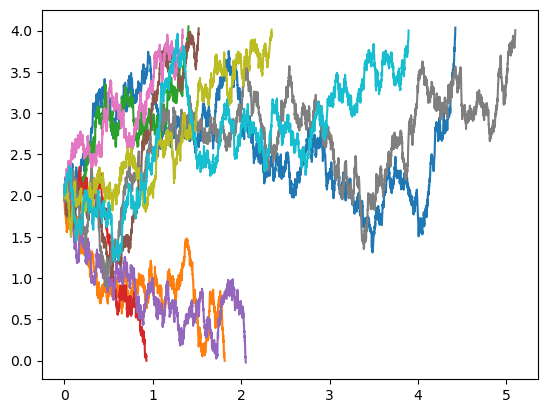

In [68]:
for traj in trajs[:10]:
    plt.plot(traj[0], traj[1])

In [75]:
x, u=ddm.FirstPassageTime_density(a=4, z=1, T=1, Nx=1000, N=1000)

(1000, 1)
(1000, 1000)
(1000,)


In [76]:
x.shape, u.shape

((1000,), (1000,))

In [77]:
x1, u1 = ddm.FokkerPlanck_CN(a=4, z=1, T=1, Nx=1000, Nt=1000, delta_approx="Rectangular")
x2, u2 = ddm.FokkerPlanck_CN(a=4, z=1, T=1, Nx=1000, Nt=1000, delta_approx="Quadratic")
x3, u3 = ddm.FokkerPlanck_CN(a=4, z=1, T=1, Nx=1000, Nt=1000, delta_approx="Gaussian")
x4, u4 = ddm.FokkerPlanck_CN(a=4, z=1, T=1, Nx=1000, Nt=1000, delta_approx="Kronecker")
x5, u5 = ddm.FokkerPlanck_CN(a=4, z=1, T=1, Nx=1000, Nt=1000, delta_approx="Triangle")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


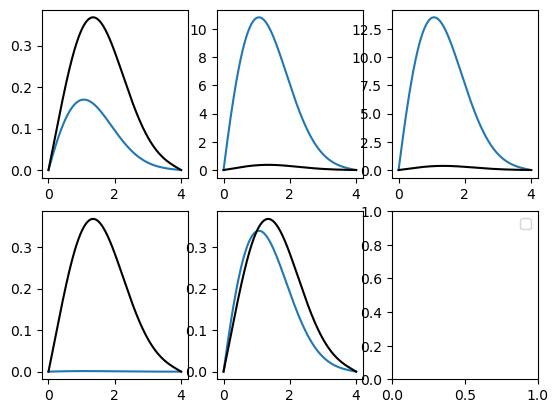

In [78]:
fig, ax = plt.subplots(2,3)
ax[0,0].plot(x1,u1, label='Rectangular')
ax[0,0].plot(x,u, label='analytical', c='k')

ax[0,1].plot(x2,u2, label='Quadratic')
ax[0,1].plot(x,u, label='analytical', c='k')

ax[0,2].plot(x3,u3, label='Gaussian')
ax[0,2].plot(x,u, label='analytical', c='k')

ax[1,0].plot(x4,u4, label='Kronecker')
ax[1,0].plot(x,u, label='analytical', c='k')

ax[1,1].plot(x5,u5, label='Triangle')
ax[1,1].plot(x,u, label='analytical', c='k')

plt.legend()

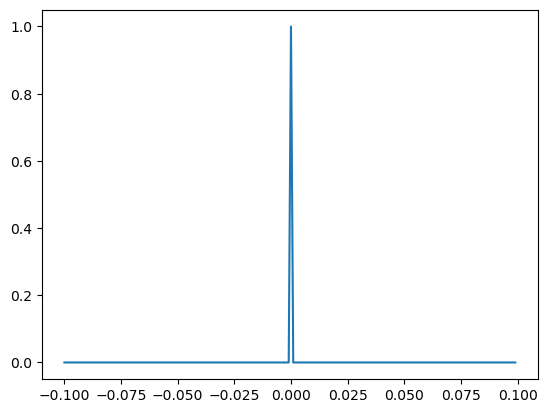

In [65]:
def RectangularDelta(x, L):
    return 1 / (2 * L) * (np.abs(x) < L)


def TriangleDelta(x, L):
    return (1 / L - np.abs(x) / L ** 2) * (np.abs(x) < L)


def QuadraticDelta(x, L):
    return L / np.pi / (x ** 2 + L ** 2)


def GaussianDelta(x, L):
    return 1 / (np.sqrt(2 * np.pi) * L) * np.exp(-(x ** 2) / (2 * L ** 2))


def KroneckerDelta(x):
    return 1 * (np.abs(x) < 1e-8)


x = np.arange(-0.1, 0.1, 0.001)
y1 = RectangularDelta(x, 0.01)
y2 = TriangleDelta(x, 0.01)
y3 = QuadraticDelta(x, 0.01)
y4 = GaussianDelta(x, 0.01)
y5 = KroneckerDelta(x)

# plt.plot(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.plot(x, y5)


In [ ]:
y5

To approximate this process,  we discretize the time and space with step size $\Delta t$ and $\Delta x$ respectively, 
and consider a discrete-time discrete-space Markov chain $\tilde{X}$ on the grid. We want the temporal interpolation of $\tilde{X}_j$ converges in distribution to $X$ as $\Delta t, \Delta x\rightarrow 0$.

Let $Z_0, Z_1, \cdots $ be a sequence of independent random variables with
$$
Z_{j}=\left\{
\begin{array}{ll}
      \Delta x & \text{w.p. } p^{+}_j \\
      0 & \text{w.p. } 1-p^{+}_j-p^{-}_j \\
      -\Delta x & \text{w.p. } p^{-}_j \\
\end{array} 
\right.  
$$
and $Y_n=\sum_{j=1}^n Z_j$ be the random walk of $Z_j$. Let $\Omega=\{0, 1, 2, \cdots, N_x, \beta\}$ be the state space of $\tilde{X}_j$, where $\beta$ is the absorbing state. When $0\le Y_j\le a$, we take $\tilde{X}_j=Y_j/\Delta x$; once $Y_j$ hits the boundary $0$ or $a$, we move the next step $\tilde{X}_j$ to the absorbing state $\beta$. Then the transition probability of $\tilde{X}_j$'s would be
$$
\mathcal{p}_{s_1s_2}(t_j)=\mathbb{P}(\tilde{X}_{j+1}=s_2\Delta x|\tilde{X}_{j}=s_1\Delta x)=
\left\{
\begin{array}{ll}
\mathbb{P}(Y_{j+1}=s_2\Delta x|Y_{j}=s_1\Delta x)=
\left\{
\begin{array}{ll}
      p^{+}_j & \text{if  } s_2-s_1=1 \\
      1-p^{+}_j-p^{-}_j & \text{if  } s_2-s_1=0 \\
      p^{-}_j & \text{if  } s_2-s_1=-1 \\
\end{array} 
\right. & \text{if  } s_1,s_2\in\Omega\backslash\{0,N_x,\beta\} \\
      1 & \text{if  } s_1\in\{0,N_x,\beta\}, s_2=\beta\\
      0 & \text{otherwise}  \\
\end{array} 
\right. 
$$

We try to match the first and second moment of $X((j+1)\Delta t)-X(j\Delta t)$ and $Z_j$, i.e. we let
$$
\begin{aligned}
(p_j^{+}-p_j^{-})\Delta x&=\textstyle \int_{j\Delta t}^{(j+1)\Delta t}\mu(r)\mathrm{d}r\\
(p_j^{+}+p_j^{-})(\Delta x)^2&=\left(\textstyle\int_{j\Delta t}^{(j+1)\Delta t}\mu(r)\mathrm{d}r\right)^2+\sigma^2\Delta t
\end{aligned}
$$
use a first order approximation for the integral, and let $\mu_j=\mu(j\Delta t)$, then 
$$
\begin{aligned}
(p_j^{+}-p_j^{-})\Delta x&=\mu_j\Delta t\\
(p_j^{+}+p_j^{-})(\Delta x)^2&=\mu_j^2(\Delta t)^2+\sigma^2\Delta t
\end{aligned}
$$
from which we can solve for $p_j^+$ and $p_j^-$ explicitly.
Note that we need to take suitable values of $\Delta t$ and $\Delta x$ to make $p_j^+$ and $p_j^-$ meaningful.

In [ ]:
class approx_hmc(nx.DiGraph):
    """
    Markov chain approximation (homogeneous case)
    """

    def __init__(self, mu, sigma, a, z, dt, Nx, verbose=True) -> None:
        self.mu = mu  # drift coeff (constant)
        self.sigma = sigma  # diffusion coeff (constant)
        self.a = a  # upper boundary
        self.z = z  # starting point
        self.Nx = Nx  # num of space steps

        self.dt = dt
        dx = a / Nx
        self.dx = dx

        self.idx_z = int(round(z / dx))  # index of starting point
        self.init_dist = np.zeros(self.Nx + 2)
        self.init_dist[self.idx_z] = 1

        # transition probability matrix
        # 0, 1, ..., Nx are transient states
        # Nx+1 is the absorbing state
        m1 = mu * dt
        m2 = (mu * dt) ** 2 + sigma ** 2 * dt
        self.p1 = (m2 / dx ** 2 + m1 / dx) / 2
        self.p2 = (m2 / dx ** 2 - m1 / dx) / 2
        assert self.p1 + self.p2 < 1, "p+=%.5f, p0=%.5f, p-=%.5f" % (self.p1, 1 - self.p1 - self.p2, self.p2)
        self.Construct_AdjMat()

        if verbose:
            self.summary()

    def Construct_AdjMat(self):
        AdjMat = sp.dok_array((self.Nx + 2, self.Nx + 2))
        nz_dict = {(0, self.Nx + 1): 1, 
                   (self.Nx, self.Nx + 1): 1,
                   (self.Nx + 1, self.Nx + 1): 1}
        for i in range(1, self.Nx):
            nz_dict[(i, i - 1)] = self.p2
            nz_dict[(i, i)] = 1 - self.p1 - self.p2
            nz_dict[(i, i + 1)] = self.p1
        dict.update(AdjMat, nz_dict)
        self.AdjMat = sp.csr_array(AdjMat)
        super(approx_hmc, self).__init__(self.AdjMat)

    def ExitDist(self, T):
        """
        compute the full distribution of X[T]
        where T is the first passage time 
        by MATRIX MULTIPLICATION
        """
        dist_Xt = self.init_dist
        idx_T = int(round(T / self.dt))
        for t_step in range(idx_T):
            dist_Xt = dist_Xt @ self.AdjMat
        return dist_Xt

    def ExitProb_dp1(self, T, s):
        """
        compute the probability of P(X[T]=s)
        where t is the first passage time
        by DYNAMIC PROGRAMMING based on SPARSE ADJACENCY MATRIX
        s: value in [0, a]
        """
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        table = np.zeros((self.Nx + 2, idx_T))
        table[:, [idx_T - 1]] = self.AdjMat[:, [idx_s]].toarray()
        for t_step in range(idx_T - 2, -1, -1):
            table[:, [t_step]] = self.AdjMat @ table[:, [t_step + 1]]
        return table[:, 0] @ self.init_dist

    def ExitProb_dp2(self, T, s):
        """
        compute the probability of P(X[T]=s)
        where t is the first passage time
        by DYNAMIC PROGRAMMING based on AJACENCY LIST
        s: value in [0, a]
        """
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        table = np.zeros((self.Nx + 2, idx_T))
        table[:, [idx_T - 1]] = self.AdjMat[:, [idx_s]].toarray()
        for t_step in range(idx_T - 2, -1, -1):
            for u, v, w in self.in_edges(data=True):
                table[u, t_step] += w["weight"] * table[v, t_step + 1]
        return table[:, 0] @ self.init_dist

    def ExitProb_logdp1(self, T, s):
        """
        compute the probability of P(X[T]=s) in LOG scale
        where t is the first passage time
        by DYNAMIC PROGRAMMING based on ADJACENCY MATRIX
        s: value in [0, a]
        """
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        logP = np.log(self.AdjMat.todense())
        logtable = np.zeros((self.Nx + 2, idx_T))
        logtable[:, [idx_T - 1]] = logP[:, [idx_s]]
        for t_step in range(idx_T - 2, -1, -1):
            logtable[:, [t_step]] = logdotexp(logP, logtable[:, [t_step + 1]])
        logprob = logdotexp(np.log(self.init_dist).reshape(1, -1), logtable[:, [0]])
        return np.squeeze(np.exp(logprob))[()]
    
    def ExitProb_logdp2(self, T, s):
        """
        compute the probability of P(X[T]=s) with a EXP scaling
        where t is the first passage time
        by DYNAMIC PROGRAMMING based on ADJACENCY MATRIX
        s: value in [0, a]
        """
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        scaled_table = np.zeros((self.Nx + 2, idx_T))
        r = 0
        scaled_table[:, [idx_T - 1]] = self.AdjMat[:, [idx_s]].toarray() / np.exp(r)
        for t_step in range(idx_T - 2, -1, -1):
            b = np.sum(self.AdjMat @ scaled_table[:, [t_step + 1]])
            r = r + np.log(b)
            scaled_table[:, [t_step]] = self.AdjMat @ scaled_table[:, [t_step + 1]] / b
        return scaled_table[:, 0] * np.exp(r) @ self.init_dist
        

    def ExitProb_test(self, T, s):
        """
        compute the probability of P(X[T]=s)
        where t is the first passage time
        by BRUTAL FORCE (only used for testing!)
        s: value in [0, a]
        """
        idx_T = int(round(T / self.dt))
        idx_s = int(round(s / self.dx))
        ranges = [range(self.Nx + 2)] * (idx_T - 1)
        prob = 0
        for xs in itertools.product(*ranges):
            prob_traj = self.AdjMat[self.idx_z, xs[0]] * self.AdjMat[xs[-1], idx_s]
            for l in range(len(xs) - 1):
                prob_traj *= self.AdjMat[xs[l], xs[l + 1]]
            prob += prob_traj
        return prob

    def summary(self):
        print("mu: %.3f" % self.mu)
        print("sigma: %.3f" % self.sigma)
        print("a: %.3f" % self.a)
        print("z: %.3f" % self.z)
        print("dt: %.5f" % self.dt)
        print("dx: %.5f" % self.dx)
        print("Nx: %d" % self.Nx)
        print("shape of P: " + str(self.AdjMat.shape))
        print("p+, p0, p-: %.5f, %.5f, %.5f" % (self.p1, 1 - self.p1 - self.p2, self.p2))


Let $\tau=\inf\{j\ge0:\tilde{X}_j=0\text{ or }a\}$ be the first passage time of $\tilde{X}_j$ through the boundary.
We want to compute 
$\mathbb{P}(\tilde{X}_\tau=0)$ and $\mathbb{P}(\tilde{X}_\tau=a)$, or more generally $\mathbb{P}(\tilde{X}_\tau=x_\tau)$

$$
\begin{aligned}
\mathbb{P}(\tilde{X}_\tau=x_\tau)
&=\sum_{x_0, x_1,\cdots, x_{\tau-1}} \mathbb{P}(\tilde{X}_\tau=x_\tau|\tilde{X}_{\tau-1}=x_{\tau-1})\mathbb{P}(\tilde{X}_{\tau-1}=x_{\tau-1}|\tilde{X}_{\tau-2}=x_{\tau-2})\cdots\mathbb{P}(\tilde{X}_1=x_1|\tilde{X}_{0}=x_0)\mathbb{P}(\tilde{X}_{0}=x_0)\\
&=\sum_{x_0, x_1,\cdots, x_{\tau-2}}\underbrace{\sum_{x_{\tau-1}} \mathbb{P}(\tilde{X}_\tau=x_\tau|\tilde{X}_{\tau-1}=x_{\tau-1})\mathbb{P}(\tilde{X}_{\tau-1}=x_{\tau-1}|\tilde{X}_{\tau-2}=x_{\tau-2})}_{f_{\tau-2}(x_{\tau-2})}\cdots\mathbb{P}(\tilde{X}_1=x_1|\tilde{X}_{0}=x_0)\mathbb{P}(\tilde{X}_{0}=x_0)\\
&=\sum_{x_0, x_1,\cdots, x_{\tau-3}}\underbrace{\sum_{x_{\tau-2}}f_{\tau-2}(x_{\tau-2})\mathbb{P}(\tilde{X}_{\tau-2}=x_{\tau-2}|\tilde{X}_{\tau-3}=x_{\tau-3})}_{f_{\tau-3}(x_{\tau-3})}\cdots\mathbb{P}(\tilde{X}_1=x_1|\tilde{X}_{0}=x_0)\mathbb{P}(\tilde{X}_{0}=x_0)\\
&=\cdots\\
&=\sum_{x_0}\underbrace{\sum_{x_{1}}f_{1}(x_{1})\mathbb{P}(\tilde{X}_{1}=x_{1}|\tilde{X}_{0}=x_{0})}_{f_{0}(x_{0})}\mathbb{P}(\tilde{X}_{0}=x_0)\\

\end{aligned}
$$
In fact $f_j(x_j)=\mathbb{P}(\tilde{X}_{\tau}=x_\tau\Delta x|\tilde{X}_{j}=x_j\Delta x)$ here.

$$
\begin{aligned}
f_{\tau-1}(x_{\tau-1})&= P(t_{\tau-1})[x_{\tau-1},x_\tau]\\
f_{\tau-2}(x_{\tau-2})&=\sum_{x_{\tau-1}} \mathbb{P}(\tilde{X}_\tau=x_\tau|\tilde{X}_{\tau-1}=x_{\tau-1})\mathbb{P}(\tilde{X}_{\tau-1}=x_{\tau-1}|\tilde{X}_{\tau-2}=x_{\tau-2})\\
&=\sum_{x_{\tau-1}} p_{x_{\tau-1},x_\tau}(t_{\tau-1})p_{x_{\tau-2},x_{\tau-1}}(t_{\tau-2})\\
&=P(t_{\tau-2})[x_{\tau-2},:]\cdot P(t_{\tau-1})[:,x_\tau]\\
&=P(t_{\tau-2})[x_{\tau-2},:]\cdot f_{\tau-1}\\
f_{\tau-3}(x_{\tau-3})&=\sum_{x_{\tau-2}} f_{\tau-2}(x_{\tau-2})p_{x_{\tau-3},x_{\tau-2}}(t_{\tau-3})\\
&=\text{row $x_{\tau-3}$ of $P(t_{\tau-3})$} \cdot f_{\tau-2}\\
&\cdots\\
&\cdots\\
\underbrace{f_{j}(x_j)}_{\in\mathbb{R}}&=\sum_{x_{j+1}} p_{x_j,x_{j+1}}(t_{j})f_{j+1}(x_{j+1})=\underbrace{P(t_{j})[x_j,:]}_{\in\mathbb{R}^{1\times N}} \cdot \underbrace{f_{j+1}}_{\in\mathbb{R}^{N\times 1}}\\
\Rightarrow \underbrace{f_{j}}_{\in\mathbb{R}^{N\times1}}&=\underbrace{P(t_{j})}_{\in\mathbb{R}^{N\times N}} \cdot \underbrace{f_{j+1}}_{\in\mathbb{R}^{N\times1}}\\
\end{aligned}
$$

to prevent numerical underflow:
$$
\begin{aligned}
f_{j}(x_j)&=\sum_{x_{j+1}} p_{x_j,x_{j+1}}(t_{j})f_{j+1}(x_{j+1})\\
&=\sum_{x_{j+1}} p_{x_j,x_{j+1}}(t_{j})\tilde{f}_{j+1}(x_{j+1})e^{r_j}\\
&=e^{r_{j+1}}\sum_{x_{j+1}} p_{x_j,x_{j+1}}(t_{j})\tilde{f}_{j+1}(x_{j+1})\\
&=\underbrace{e^{r_{j+1}}\sum_{x_j, x_{j+1}} p_{x_j,x_{j+1}}(t_{j})\tilde{f}_{j+1}(x_{j+1})}_{e^{r_j}}\frac{\sum_{x_{j+1}} p_{x_j,x_{j+1}}(t_{j})\tilde{f}_{j+1}(x_{j+1})}{\sum_{x_j, x_{j+1}} p_{x_j,x_{j+1}}(t_{j})\tilde{f}_{j+1}(x_{j+1})}\\
\end{aligned}
$$
Procedures:

$$
\begin{aligned}
\bullet &\text{  $f_{\tau-1}=P[:,x_\tau]$. Let $\tilde{f}_{\tau-1}=f_{\tau-1}/e^{r_{\tau-1}}$, with some suitable $r$}\\
\bullet &\text{  In the $j$-th time step: Let } b=\textstyle \sum P\cdot\tilde{f}_{j+1}, \\
& \text{Since $f_{j}=P\cdot f_{j+1}=e^{r_{j+1}}\left(P\cdot\tilde{f}_{j+1}\right)=\left(e^{r_{j+1}}b\right)\left(P\cdot\tilde{f}_{j+1}/b\right)$},\\
& \text{ let $r_{j}=r_{j+1}+\log b$, $\tilde{f}_j=P\cdot\tilde{f}_{j+1}/b$}\\
\bullet & \text{ In the last step,  $f_0=\tilde{f}_0e^{r_0}$}
\end{aligned}
$$

In [ ]:
mc1 = approx_hmc(mu=0.2, sigma=1, a=4, z=2, dt=0.01, Nx=4)

In [ ]:
nx.adjacency_matrix(mc1).todense()

#### An example:
$\mu=0.2, \sigma=1, a=4, z=2$. Set $\Delta t=0.1, \Delta x=0.8$, the state space $\Omega=\{0, 1,2,3,4,5,\beta\}$. The process exits boundary $a=0$ at time $1\ \mathrm{s}$.

In [ ]:
mc1 = approx_hmc(mu=0.2, sigma=1, a=4, z=2, dt=0.001, Nx=100)

In [ ]:
T = 1
mc1.ExitDist(T)

In [ ]:
[mc1.ExitProb_dp1(T, i*mc1.dx) for i in range(mc1.Nx+1)]

In [ ]:
[mc1.ExitProb_dp2(T, i*mc1.dx) for i in range(mc1.Nx+1)]

In [ ]:
[mc1.ExitProb_logdp1(T, i*mc1.dx) for i in range(mc1.Nx+1)]

In [ ]:
[mc1.ExitProb_logdp2(T, i*mc1.dx) for i in range(mc1.Nx+1)]

In [ ]:
[mc1.ExitProb_test(T, i*mc1.dx) for i in range(mc1.Nx+1)]

The first passage

In [ ]:
def LogLikelihood(chain, data):
    """
    compute the likelihood: product of P(X(Tk)=Ck)
    """
    logprob = 0 
    for Ck, Tk in data:
        logprob += np.log(chain.ExitProb_logdp(Tk, Ck))
        if np.isinf(logprob):
            raise ValueError('Infty detected, computation is stopped.')
    return logprob

In [3]:
LogLikelihood(mc1, data)

NameError: name 'mc1' is not defined

In [2]:
mu_list = np.arange(-1, 1, 0.005)
probs_list = []
for mu in mu_list:
    chain = approx_hmc(mu=mu, sigma=1, a=4, z=2, dt=0.001, Nx=100, verbose=False)
    probs_list.append(LogLikelihood(chain, data))

NameError: name 'np' is not defined

In [ ]:
print(probs_list)

In [ ]:
plt.plot(mu_list, probs_list)

In [ ]:
mu_list[np.argmax(probs_list)]